In [ ]:
# --- imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from pygam import LinearGAM, s, te, f

# =========================
# 1) Config básica
# =========================
SENSORS = ['28079035', '28079050', '28079056']
SPLIT_DATE = '2024-01-01'


# features (orden = índice de columna en X)
FEATURES = [
    'intensidad_lag8',   # 0
    't2m_ma6',           # 1
    'd2m_ma6',           # 2
    'sp_anom',           # 3 (se crea abajo)
    'wind_speed_ma24',   # 4
    'wind_dir_sin_ma6',  # 5  (solo sin)
    'tp_sum24',          # 6
    'ssr_sum24_anom',    # 7 (se crea abajo)
    'hour_sin',          # 8   \
    'hour_cos',          # 9    > tensor 1 (hora)
    'day_of_week_sin',   # 10  \
    'day_of_week_cos',   # 11   > tensor 2 (día semana)
    'season_sin',        # 12  \
    'season_cos',        # 13   > tensor 3 (estación)
    'weekend'            # 14   factor
]

# mapping de términos en el GAM (intercept = 0, luego esto)
TERM_IDX = {
    'intensidad_lag8': 0,
    't2m_ma6':          1,
    'd2m_ma6':          2,
    'sp_anom':          3,
    'wind_speed_ma24':  4,
    'wind_dir_sin_ma6': 5,
    'tp_sum24':         6,
    'ssr_sum24_anom':   7,
    'hour_pair':        8,   # te(8,9)
    'dow_pair':         9,   # te(10,11)
    'season_pair':      10,  # te(12,13)
    'weekend':          11   # f(14)
}


# =========================
# 2) Utils de features
# =========================
def add_time_features(df):
    df = df.copy()
    df['fecha'] = pd.to_datetime(df['fecha'])
    df['hour'] = df['fecha'].dt.hour
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['month'] = df['fecha'].dt.month
    df['season'] = df['month'].map(lambda m: 0 if m in [12,1,2] else 1 if m in [3,4,5] else 2 if m in [6,7,8] else 3)
    df['weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

    df['day_of_week_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

    df['season_sin'] = np.sin(2*np.pi*df['season']/4)
    df['season_cos'] = np.cos(2*np.pi*df['season']/4)
    return df

def make_gam():
    """Arquitectura fija, suave e interpretable."""
    return LinearGAM(
        s(0,  n_splines=9, lam=40) +   # intensidad_lag8
        s(1,  n_splines=9, lam=40) +   # t2m_ma6
        s(2,  n_splines=9, lam=40) +   # d2m_ma6
        s(3,  n_splines=9, lam=60) +   # sp_anom
        s(4,  n_splines=9, lam=60) +   # wind_speed_ma24
        s(5,  n_splines=6, lam=40)  +  # wind_dir_sin_ma6
        s(6,  n_splines=9, lam=60) +   # tp_sum24
        s(7,  n_splines=9, lam=60) +   # ssr_sum24_anom
        te(8,  9,  n_splines=[6,6], lam=[50,50]) +   # hora sin+cos
        te(10, 11, n_splines=[6,6], lam=[50,50]) +   # día semana sin+cos
        te(12, 13, n_splines=[6,6], lam=[50,50]) +   # estación sin+cos
        f(14)
    )

# =========================
# 3) Entrena por sensor
# =========================
def fit_by_sensor(df, sensor_id):
    idcol = 'id_no2'
    d = df[df[idcol] == sensor_id].copy()
    d = add_time_features(d)

    # split temporal
    train = d[d['fecha'] < SPLIT_DATE].copy()
    test  = d[d['fecha'] >= SPLIT_DATE].copy()

    # anomalies (centradas en TRAIN del propio sensor)
    train['sp_anom'] = train['sp'] - train['sp'].mean()
    test['sp_anom']  = test['sp']  - train['sp'].mean()

    train['ssr_sum24_anom'] = train['ssr_sum24'] - train['ssr_sum24'].mean()
    test['ssr_sum24_anom']  = test['ssr_sum24']  - train['ssr_sum24'].mean()

    X_train = train[FEATURES].values
    X_test  = test[FEATURES].values
    y_train = train['no2_value'].values
    y_test  = test['no2_value'].values

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    gam = make_gam().fit(X_train_s, y_train)
    rmse = sqrt(mean_squared_error(y_test, gam.predict(X_test_s))) if len(y_test) else np.nan
    return {'gam': gam, 'scaler': scaler, 'train': train, 'test': test, 'rmse': rmse}

# =========================
# 4) Plots comparativos
# =========================

def _pd_curve_single(model, feat_idx, xgrid):
    """Efecto parcial univariante para la feature feat_idx, en unidades originales."""
    gam, scaler = model['gam'], model['scaler']
    term_idx = TERM_IDX[FEATURES[feat_idx]]          # índice de término del GAM
    XX = gam.generate_X_grid(term=term_idx, n=len(xgrid))  # grid con N=len(xgrid)
    mu, sigma = scaler.mean_[feat_idx], np.sqrt(scaler.var_[feat_idx])
    # asignar en la COLUMNA de la FEATURE, no en la del término
    XX[:, feat_idx] = (xgrid - mu) / sigma
    return gam.partial_dependence(term=term_idx, X=XX)

def _pd_curve_pair(model, idx_a, idx_b, x_sin, x_cos, term_name):
    gam, scaler = model['gam'], model['scaler']
    term_idx = TERM_IDX[term_name]
    n = len(x_sin)
    p = len(FEATURES)

    mu_a, sig_a = scaler.mean_[idx_a], np.sqrt(scaler.var_[idx_a])
    mu_b, sig_b = scaler.mean_[idx_b], np.sqrt(scaler.var_[idx_b])

    XX = np.zeros((n, p))  # resto en su valor típico estandarizado 0
    XX[:, idx_a] = (x_sin - mu_a) / sig_a
    XX[:, idx_b] = (x_cos - mu_b) / sig_b

    return gam.partial_dependence(term=term_idx, X=XX)



def plot_compare(models):
    colors = {SENSORS[0]:'C0', SENSORS[1]:'C1', SENSORS[2]:'C2'}

    # grids comunes (en unidades originales)
    mins, maxs = {}, {}
    for i, f in enumerate(FEATURES[:8]):  # solo las 8 univariantes
        vals = []
        for m in models.values():
            vals.append(m['train'][f if f not in ('sp_anom','ssr_sum24_anom') else f].values
                        if f in m['train'].columns else m['train'][f].values)
        v = np.concatenate(vals)
        mins[f], maxs[f] = np.nanpercentile(v, 1), np.nanpercentile(v, 99)
    # pares cíclicos
    H = np.linspace(0, 24, 200)                  # hora
    H_sin, H_cos = np.sin(2*np.pi*H/24), np.cos(2*np.pi*H/24)
    D = np.linspace(0, 6, 200)                   # día semana
    D_sin, D_cos = np.sin(2*np.pi*D/7), np.cos(2*np.pi*D/7)
    S = np.linspace(0, 4, 200)                   # estación
    S_sin, S_cos = np.sin(2*np.pi*S/4), np.cos(2*np.pi*S/4)

    # figura
    panels = [
        ('intensidad_lag8',), ('t2m_ma6',),
        ('d2m_ma6',), ('sp_anom',),
        ('wind_speed_ma24',), ('wind_dir_sin_ma6',),
        ('tp_sum24',), ('ssr_sum24_anom',),
        ('hour_pair','Hora del día (h)'), ('dow_pair','Día de la semana'), ('season_pair','Estación'),
        ('weekend',)
    ]
    n = len(panels)
    ncols = 2
    nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*3.2), constrained_layout=True)
    axes = axes.flatten()

    for ax, p in zip(axes, panels):
        name = p[0]
        if name in ('hour_pair','dow_pair','season_pair'):
            if name == 'hour_pair':
                x, sinv, cosv, xlabel = H, H_sin, H_cos, p[1]
                a, b, term_name = 8, 9, 'hour_pair'
            elif name == 'dow_pair':
                x, sinv, cosv, xlabel = D, D_sin, D_cos, p[1]
                a, b, term_name = 10, 11, 'dow_pair'
            else:
                x, sinv, cosv, xlabel = S, S_sin, S_cos, p[1]
                a, b, term_name = 12, 13, 'season_pair'

            for sid, m in models.items():
                y = _pd_curve_pair(m, a, b, sinv, cosv, term_name)
                ax.plot(x, y, lw=1.6, label=str(sid), color=colors[sid])
            ax.set_xlabel(xlabel)
        elif name == 'weekend':
            xs = np.array([0, 1], dtype=float)
            for sid, m in models.items():
                mu, sig = m['scaler'].mean_[14], np.sqrt(m['scaler'].var_[14])
                term = TERM_IDX['weekend']
                XX = np.zeros((len(xs), len(FEATURES)))
                XX[:, 14] = (xs - mu) / sig
                y = m['gam'].partial_dependence(term=term, X=XX)
                ax.plot(xs, y, marker='o', lw=1.6, label=str(sid), color=colors[sid])
            ax.set_xticks([0,1]); ax.set_xticklabels(['Laborable','Fin de semana'])
        else:
            feat = name
            x = np.linspace(mins[feat], maxs[feat], 200)
            for sid, m in models.items():
                j = FEATURES.index(feat)
                y = _pd_curve_single(m, j, x)
                ax.plot(x, y, lw=1.6, label=str(sid), color=colors[sid])
            ax.set_xlabel(feat)

        ax.axhline(0, ls='--', lw=.7, c='grey'); ax.grid(alpha=.25)
        ax.set_title(name)

    # leyenda única
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, [f'{lab} (RMSE={models[lab]["rmse"]:.1f})' for lab in labels],
            loc='upper center', ncol=3, frameon=False)

    fig.suptitle('Efectos parciales comparados (GAM) — sensores 28079035 / 28079050 / 28079056',
                 y=1.02, fontsize=13)
    
    # apaga ejes sobrantes
    for k in range(len(panels), len(axes)):
        axes[k].axis('off')
    plt.show()

In [2]:
df = pd.read_parquet("../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet")

28079035 RMSE test = 15.34
28079050 RMSE test = 14.57
28079050 RMSE test = 14.57
28079056 RMSE test = 19.27
28079056 RMSE test = 19.27


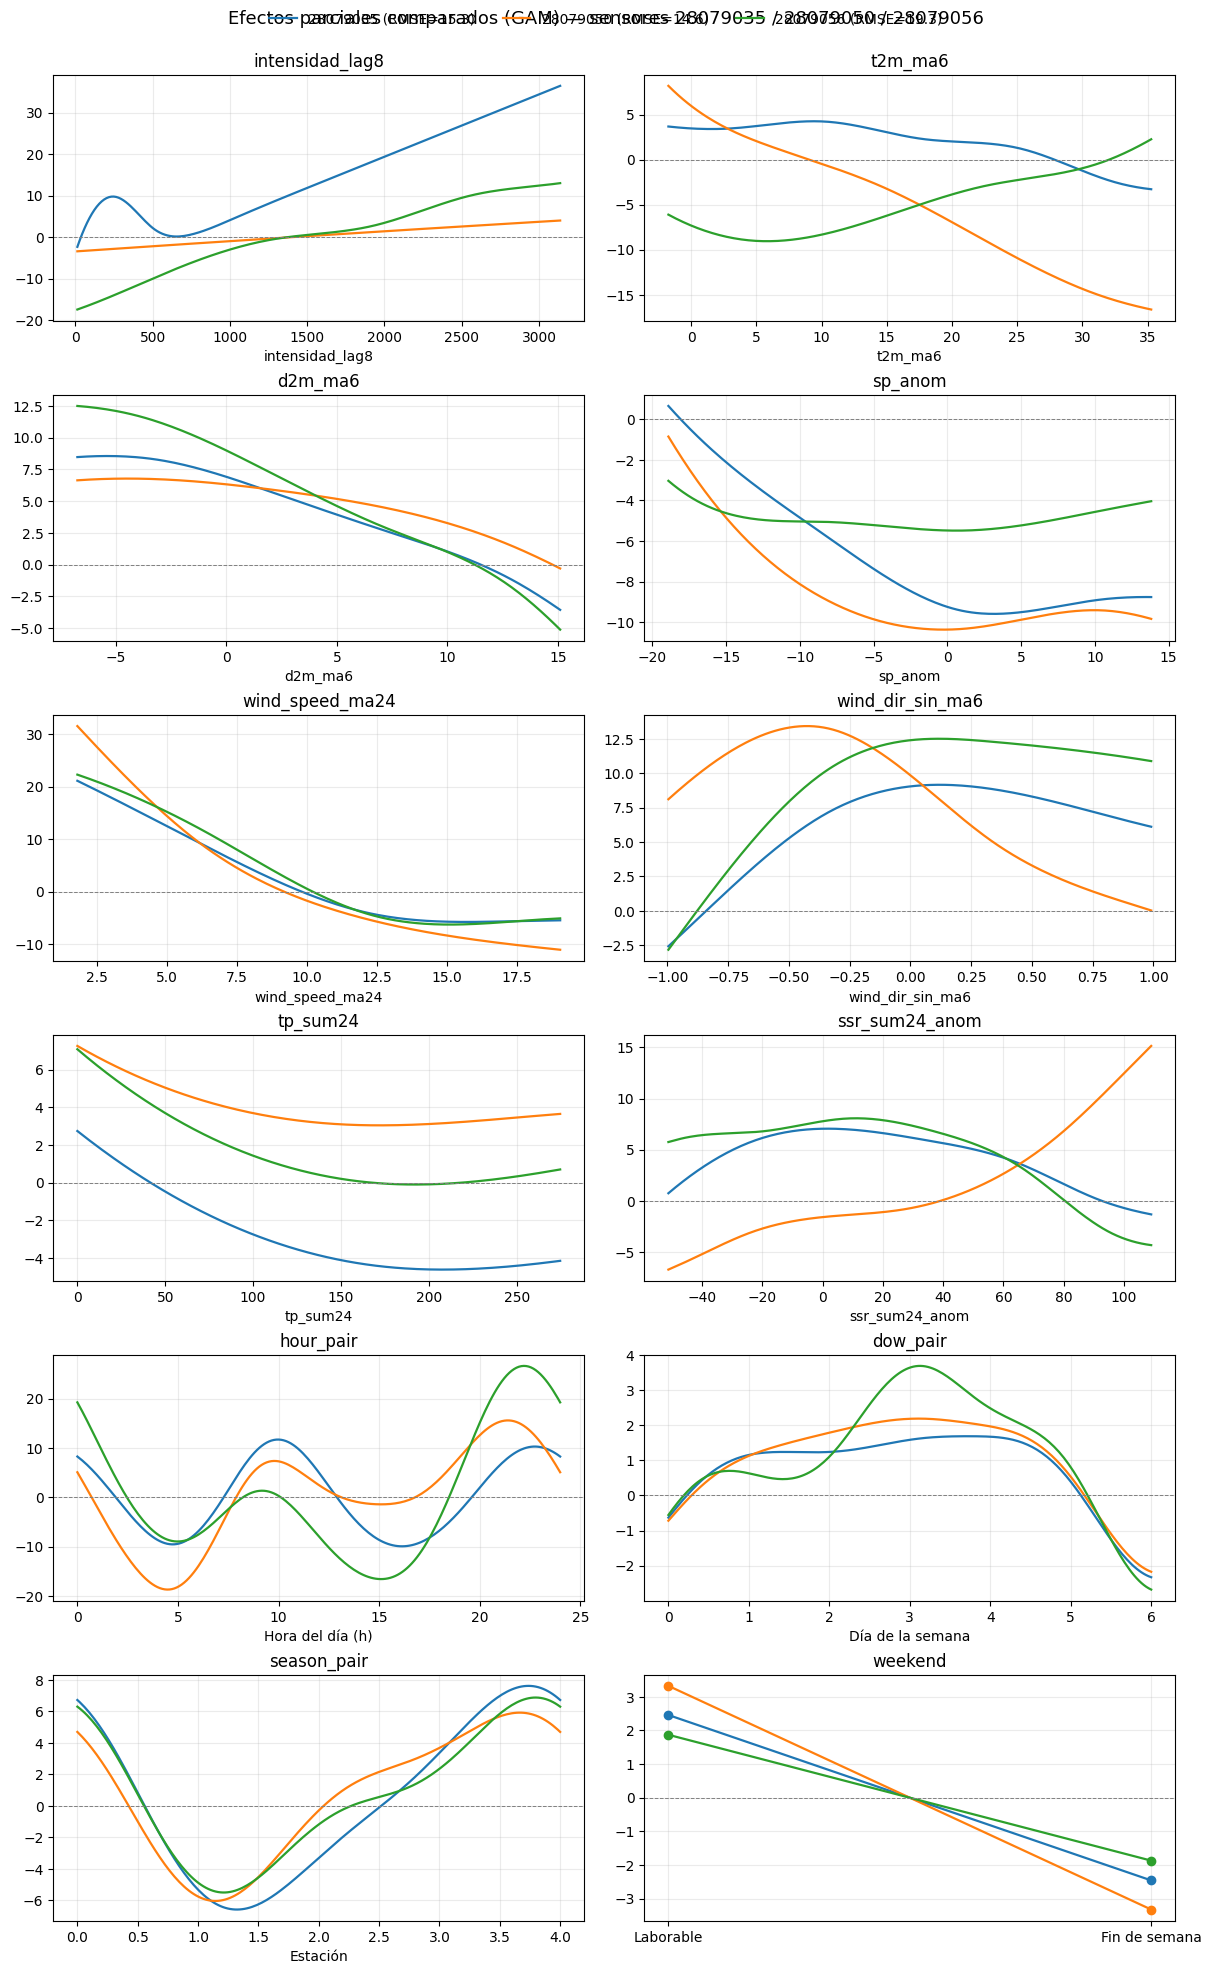

In [3]:

# =========================
# 5) Ejecutar
# =========================
# df = pd.read_parquet('tu_dataset.parquet')  # <- carga tu DF aquí
# Asegúrate de que df tiene 'no2_value' y columnas usadas en FEATURES + 'sp' y 'ssr_sum24'

models = {}
for sid in SENSORS:
    models[sid] = fit_by_sensor(df, sid)
    print(sid, 'RMSE test =', round(models[sid]['rmse'], 2))

plot_compare(models)